In [31]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
import chart_studio.plotly as py
import calendar
from pylab import rcParams
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib as mpl

### Đánh giá tổng quan bảng subs

Nhập bảng dữ liệu daily_subs đã được xử lý giá trị missing

In [32]:
df_sub= pd.read_csv('daily_subs_fillnaf.csv')
df_sub

,date,subs
0,2021-04-01,2973.000000
1,2021-04-02,2864.000000
2,2021-04-03,3014.000000
3,2021-04-04,3118.000000
4,2021-04-05,2894.000000
...,...,...
680,2023-02-10,11327.000000
681,2023-02-11,13087.000000
682,2023-02-12,11866.428571
683,2023-02-13,11138.000000


In [33]:
df_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 685 entries, 0 to 684
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    685 non-null    object 
 1   subs    685 non-null    float64
dtypes: float64(1), object(1)
memory usage: 10.8+ KB


In [34]:
#chuyển thành kiểu datetime
df_sub['date']= pd.to_datetime(df_sub['date'])
min_date= df_sub['date'].min()
max_date= df_sub['date'].max()
print('Ngày xa nhất: ', min_date)
print('Ngày gần nhất: ', max_date)

Ngày xa nhất:  2021-04-01 00:00:00
Ngày gần nhất:  2023-02-14 00:00:00


In [35]:
df_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 685 entries, 0 to 684
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    685 non-null    datetime64[ns]
 1   subs    685 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 10.8 KB


In [36]:
df_sub.isnull().sum()

date    0
subs    0
dtype: int64

In [37]:
df_sub.describe()

,date,subs
count,685,685.000000
mean,2022-03-09 00:00:00,7596.289514
min,2021-04-01 00:00:00,2839.000000
25%,2021-09-19 00:00:00,6138.000000
50%,2022-03-09 00:00:00,7152.000000
75%,2022-08-27 00:00:00,9067.000000
max,2023-02-14 00:00:00,15550.000000
std,NaN,2350.129531


In [38]:
#tạo cột tháng
def get_month(x):
    return pd.Timestamp(x.year, x.month, 1)
df_sub['month']= df_sub['date'].apply(get_month)
df_sub.head()

,date,subs,month
0,2021-04-01,2973.0,2021-04-01
1,2021-04-02,2864.0,2021-04-01
2,2021-04-03,3014.0,2021-04-01
3,2021-04-04,3118.0,2021-04-01
4,2021-04-05,2894.0,2021-04-01


Text(0.5, 1.0, 'Biểu đồ số lượng đăng ký theo tháng')

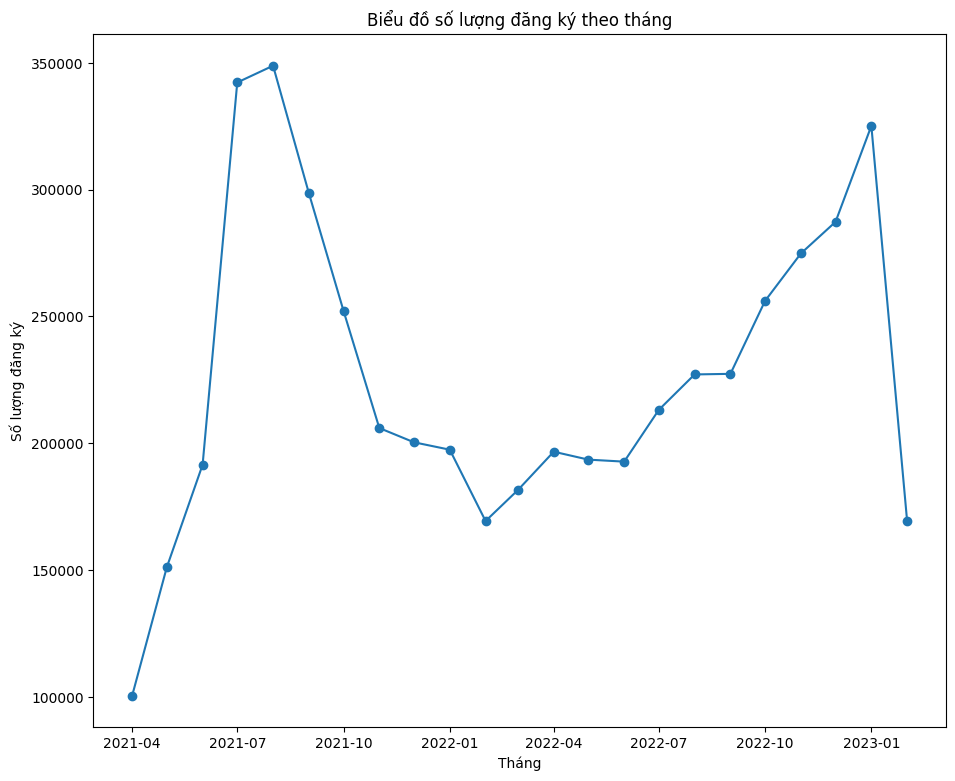

In [39]:
#vẽ biểu đồ số lượng subs theo tháng
df_sub_month= df_sub.groupby('month')['subs'].sum().reset_index()
plt.plot(df_sub_month['month'], df_sub_month['subs'], marker='o')
rcParams['figure.figsize'] = 11, 9
plt.xlabel('Tháng')
plt.ylabel('Số lượng đăng ký')
plt.title('Biểu đồ số lượng đăng ký theo tháng')

Lượng subs biến động, chạm đỉnh 3 lần tại các thời điểm 6-8/2021, 1-2023. Có 1 điểm trigger point tại tháng 6-2022. Xu hướng trong giai đoạn từ 8-2021 đến 2-2022 là một sự sụt giảm đáng quan tâm. Cần xem xét có chuyện gì đã xảy ra trong giai đoạn này.

Text(0.5, 1.0, 'Lượng đăng ký theo ngày')

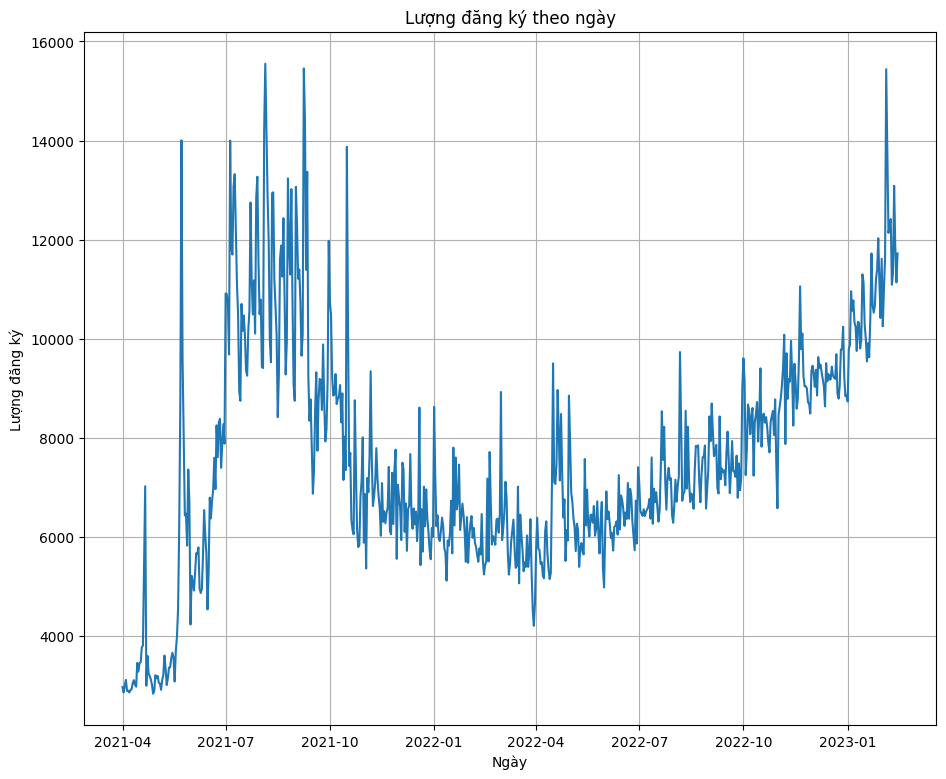

In [40]:
#vẽ biêu đồ lượng subs theo ngày
plt.plot(df_sub['date'], df_sub['subs'])
plt.grid(True)
rcParams['figure.figsize'] = 11, 9
plt.xlabel('Ngày')
plt.ylabel('Lượng đăng ký')
plt.title('Lượng đăng ký theo ngày')

Text(0, 0.5, 'Lượng đăng ký')

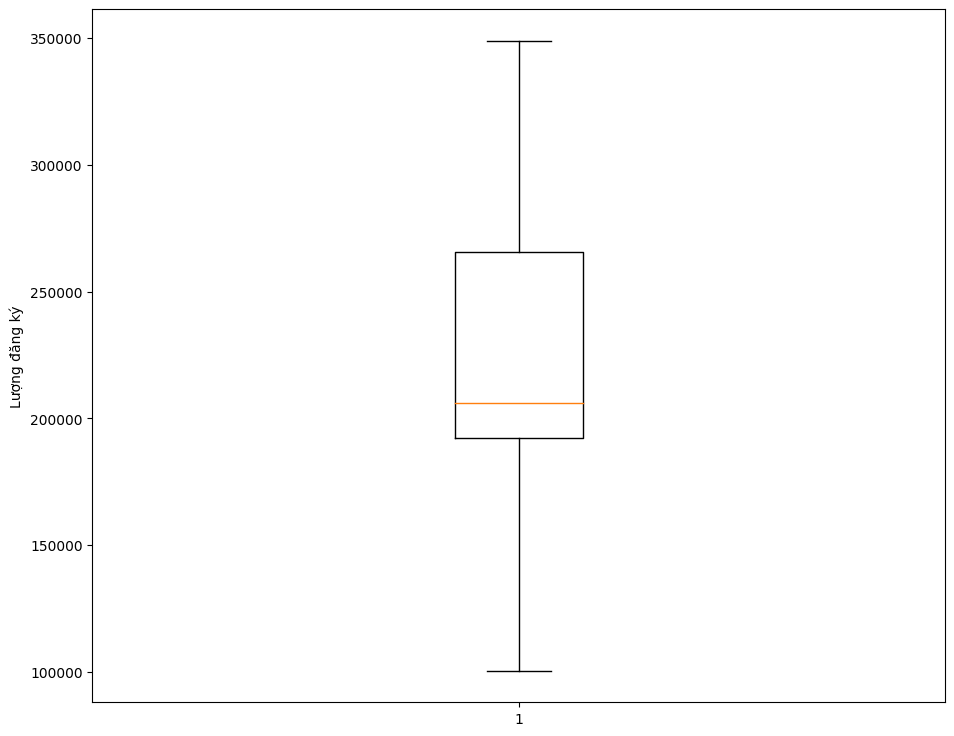

In [41]:
#vẽ boxplot tổng số lượng đăng ký theo tháng
plt.boxplot(df_sub_month['subs'])
plt.ylabel('Lượng đăng ký')

### Đánh giá tổng quan bảng time_line

Nhập bảng time_line đã được bổ sung show

In [42]:
#tách bảng thành 3 cột
df_time_line = pd.read_csv('Data bổ sung_Movie_Show - Trang tính3.csv')
df_time_line.head()

,Movie_Show,Month_Start,Month_End,Type
0,Nhanh như chớp mùa 3,2020-09,2021-09,comedy
1,7 nụ cười xuân mùa 5,2021-11,2022-03,comedy
2,Ký ức vui vẻ mùa 3,2020-11,2021-05,comedy
3,Cây táo nở hoa,2021-04,2021-09,drama
4,Nhanh như chớp nhí,2020-09,2021-09,comedy


In [43]:
df_time_line.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Movie_Show   32 non-null     object
 1   Month_Start  32 non-null     object
 2   Month_End    32 non-null     object
 3   Type         32 non-null     object
dtypes: object(4)
memory usage: 1.1+ KB


In [44]:
df_time_line.isnull().sum()

Movie_Show     0
Month_Start    0
Month_End      0
Type           0
dtype: int64

In [45]:
#chuyển thành dạng datetime
df_time_line['Month_Start']= pd.to_datetime(df_time_line['Month_Start'], format='%Y-%m')
df_time_line['Month_End']= pd.to_datetime(df_time_line['Month_End'], format='%Y-%m')

In [46]:
#check
min_date= df_time_line['Month_Start'].min()
max_date= df_time_line['Month_Start'].max()
print('Ngày xa nhất: ', min_date)
print('Ngày gần nhất: ', max_date)

Ngày xa nhất:  2020-06-01 00:00:00
Ngày gần nhất:  2023-05-01 00:00:00


In [47]:
#check
df_time_line['Movie_Show'].unique()

array(['Nhanh như chớp mùa 3', '7 nụ cười xuân mùa 5',
       'Ký ức vui vẻ mùa 3', 'Cây táo nở hoa', 'Nhanh như chớp nhí',
       'Những trái tim nhảy nhót', 'Anh yêu em được bao lâu',
       'Khi đàn ông là số 0', 'Đứa em thừa kế', 'Khi mẹ ra tay',
       'Hổng cần đàn ông', 'Dấu ấn hệ bản lĩnh', 'Sóng 23', 'Sóng 22',
       'Ngạc nhiên chưa', 'The Khang show', 'Thời tới rồi',
       'Ca sĩ bí ẩn mùa 5', 'Rap Việt all-star concert', 'Rap Việt mùa 2',
       'Running Man Vietnam - Chơi là chạy', 'Sóng 21', 'Giấc mơ của mẹ',
       'Nữ chủ', 'Hoa vương', 'Mặt trời mùa đông', 'Người Ấy Là Ai 2022',
       '2 ngày 1 đêm', 'The Masked Singer', 'Rap Việt 3',
       'Người Ấy Là Ai 2023', 'Hành Trình Rực Rỡ'], dtype=object)

### Xem xét mối quan hệ giữa số lượng đăng ký và chương trình đang phát

In [48]:
#tạo cột tháng diễn ra show
for i, row in df_time_line.iterrows():
    months = pd.date_range(start=row['Month_Start'], end=row['Month_End'], freq='M')
    for j, month in enumerate(months, start=1):
        col_name = f'month_occur{j}'
        df_time_line.at[i, col_name] = month.strftime('%Y-%m')
df_time_line.head(10)

,Movie_Show,Month_Start,Month_End,Type,month_occur1,month_occur2,month_occur3,month_occur4,month_occur5,month_occur6,month_occur7,month_occur8,month_occur9,month_occur10,month_occur11,month_occur12,month_occur13,month_occur14,month_occur15,month_occur16
0,Nhanh như chớp mùa 3,2020-09-01,2021-09-01,comedy,2020-09,2020-10,2020-11,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,NaN,NaN,NaN,NaN
1,7 nụ cười xuân mùa 5,2021-11-01,2022-03-01,comedy,2021-11,2021-12,2022-01,2022-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Ký ức vui vẻ mùa 3,2020-11-01,2021-05-01,comedy,2020-11,2020-12,2021-01,2021-02,2021-03,2021-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Cây táo nở hoa,2021-04-01,2021-09-01,drama,2021-04,2021-05,2021-06,2021-07,2021-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Nhanh như chớp nhí,2020-09-01,2021-09-01,comedy,2020-09,2020-10,2020-11,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,NaN,NaN,NaN,NaN
5,Những trái tim nhảy nhót,2022-08-01,2022-08-01,drama,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Anh yêu em được bao lâu,2022-06-01,2022-11-01,drama,2022-06,2022-07,2022-08,2022-09,2022-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Khi đàn ông là số 0,2021-03-01,2021-04-01,drama,2021-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Đứa em thừa kế,2021-04-01,2022-08-01,drama,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07
9,Khi mẹ ra tay,2022-02-01,2022-06-01,drama,2022-02,2022-03,2022-04,2022-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
#tạo bảng mới thể hiện show theo tháng
df_event_by_month = df_time_line.melt(id_vars='Movie_Show', value_vars=['month_occur1', 'month_occur2', 'month_occur3', 'month_occur4', 'month_occur5', 'Month_End'], var_name='Month_occur', value_name='Month')
df_event_by_month.head(10)

,Movie_Show,Month_occur,Month
0,Nhanh như chớp mùa 3,month_occur1,2020-09
1,7 nụ cười xuân mùa 5,month_occur1,2021-11
2,Ký ức vui vẻ mùa 3,month_occur1,2020-11
3,Cây táo nở hoa,month_occur1,2021-04
4,Nhanh như chớp nhí,month_occur1,2020-09
5,Những trái tim nhảy nhót,month_occur1,NaN
6,Anh yêu em được bao lâu,month_occur1,2022-06
7,Khi đàn ông là số 0,month_occur1,2021-03
8,Đứa em thừa kế,month_occur1,2021-04
9,Khi mẹ ra tay,month_occur1,2022-02


In [50]:
#chuyển dữ liệu cột Month thành datetime
df_event_by_month['Month'] = pd.to_datetime(df_event_by_month['Month'])

In [51]:
#joint 2 bảng event by month và bảng subs
df_merged= pd.merge(df_event_by_month, df_sub_month, left_on='Month', right_on='month')
df_merged.head()

,Movie_Show,Month_occur,Month,month,subs
0,7 nụ cười xuân mùa 5,month_occur1,2021-11-01,2021-11-01,206022.222222
1,Rap Việt mùa 2,month_occur2,2021-11-01,2021-11-01,206022.222222
2,Running Man Vietnam - Chơi là chạy,month_occur3,2021-11-01,2021-11-01,206022.222222
3,Thời tới rồi,Month_End,2021-11-01,2021-11-01,206022.222222
4,Ca sĩ bí ẩn mùa 5,Month_End,2021-11-01,2021-11-01,206022.222222


In [52]:
df_merged.to_csv('event_subs.csv', index=False)

In [53]:
#lọc lấy các cột cần thiết
df_event_subs= df_merged[['Movie_Show', 'Month', 'subs']]
df_event_subs.head()

,Movie_Show,Month,subs
0,7 nụ cười xuân mùa 5,2021-11-01,206022.222222
1,Rap Việt mùa 2,2021-11-01,206022.222222
2,Running Man Vietnam - Chơi là chạy,2021-11-01,206022.222222
3,Thời tới rồi,2021-11-01,206022.222222
4,Ca sĩ bí ẩn mùa 5,2021-11-01,206022.222222


Text(0.5, 1.0, 'Biểu đồ số lượng đăng ký theo show')

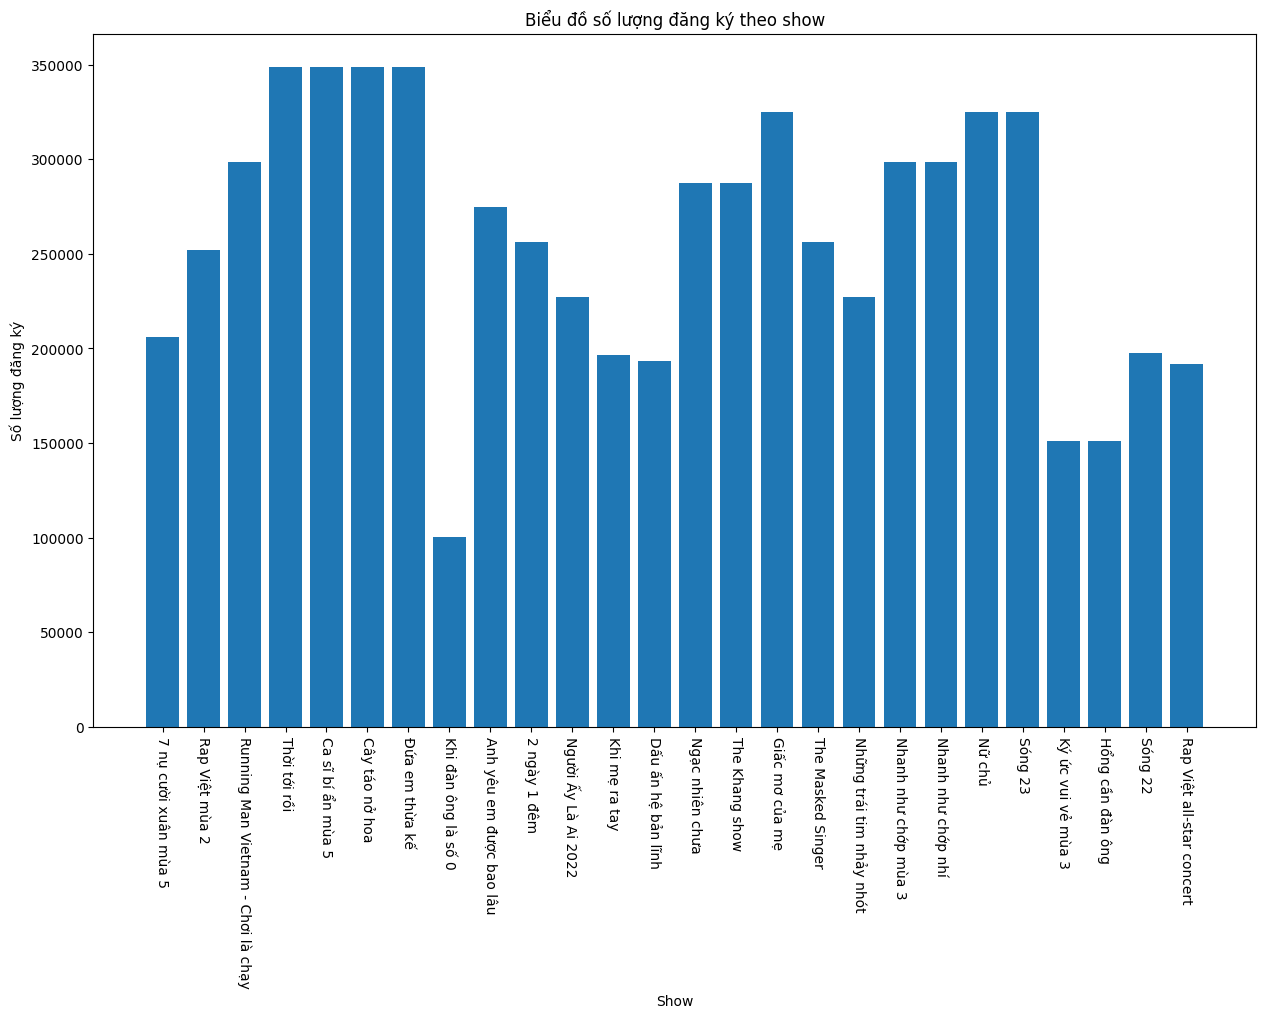

In [54]:
#vẽ biểu đồ subs theo show
rcParams['figure.figsize'] = 15, 9
plt.bar(df_event_subs['Movie_Show'], df_event_subs['subs'])
plt.xticks(rotation=-90)
plt.xlabel('Show')
plt.ylabel('Số lượng đăng ký')
plt.title('Biểu đồ số lượng đăng ký theo show')

Có những nhóm các chương trình và phim truyền hình góp mặt trong những tháng có lượt đăng ký cao. Phải xem xét tiếp đến ảnh hưởng riêng của phim và game show đến lượng sub

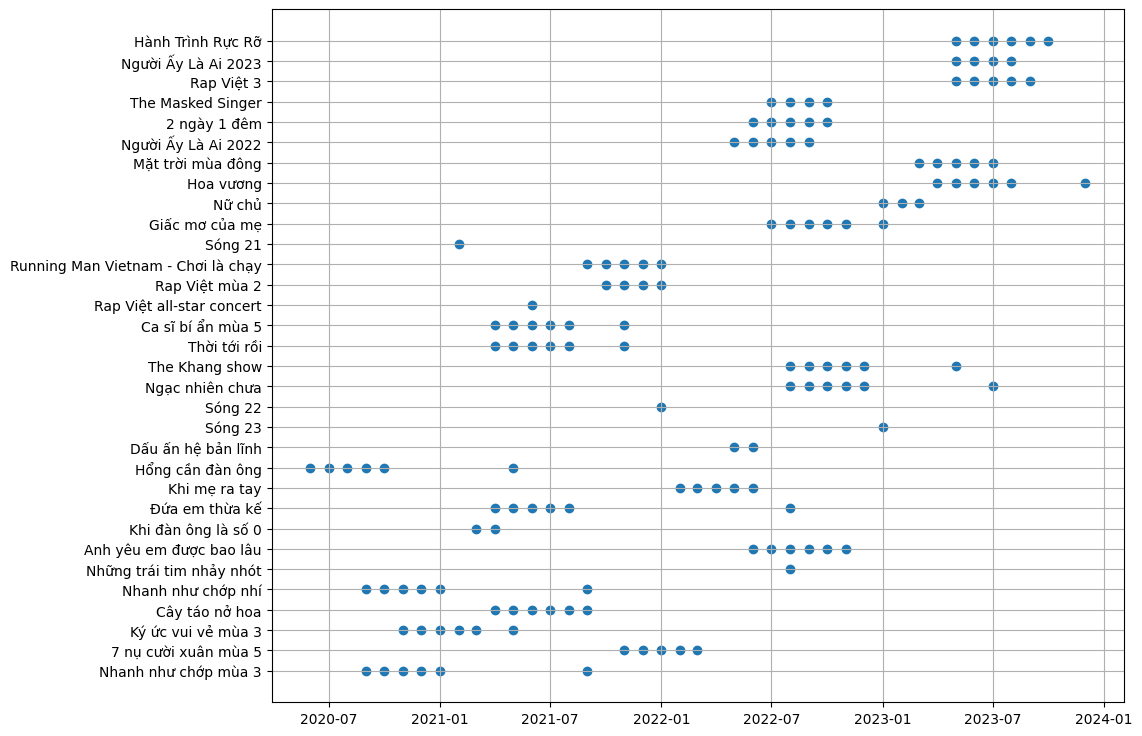

In [55]:
rcParams['figure.figsize'] = 11, 9
plt.scatter(df_event_by_month['Month'], df_event_by_month['Movie_Show'], marker='o', linestyle='-')
plt.grid()

Từ tháng 6-2022 đến tháng 10-2022 diễn ra đồng loạt nhiều show truyền hình. Đây cũng là thời điểm số lượng subs có xu hướng tăng (từ tháng 6-2022). Trong các tháng còn lại chỉ diễn ra 1 hoặc 2 show. Từ 3 phân tích trên, chứng tỏ, việc phát sóng nhiều show trong cùng một thời điểm có thể tạo ra trigger point, tức là việc chiếu nhiều show sẽ kích thích người xem đăng ký gói VIP VieOn. Đồng thời, chất lượng show sẽ tạo ra điểm chạm đỉnh của lượng subs, tức là chỉ cần có sự góp mặt của show được yêu thích nhất sẽ đạt được lượng subs cao nhất trong khoảng thời gian đó.

Dữ liệu bị thiếu
- về các show truyền hình vào trước tháng 5-2022 bị thiếu, nhưng có thể bổ sung bằng nguồn Internet
- về lượng subs của các chương trình sau tháng 2-2023, khó có thể bổ sung được

Nguyên nhân của xu hướng tăng giảm lượng subs có thể:
- Nguyên nhân có thể đoán định được:
    + Các show được phát tại thời điểm đó
    + Chiến dịch quảng bá hay sự kiện do VieOn thực hiện
    + Lễ hội và mùa trong năm
- Nguyên nhân không thể đoán định được:
    + Các sự kiện real-time: trends tiktok viral, sự kiện ra mắt phim điện ảnh mới...
    + Các show của đối thủ
    + Chương trình khuyến mãi hoặc xúc tiến của đơn vị phân phối
    + Tình hình kinh tế